Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


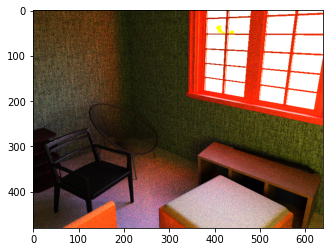

{'light_ctr': array([[3.18596612, 2.86637104, 3.        , 0.4       ]]), 'type': ['w', 'd'], 'coords': [array([[1.32600767, 1.80247232, 0.94386919],
       [1.33393098, 3.39241676, 0.94386919],
       [1.33393098, 3.39241676, 2.0542643 ],
       [1.32600767, 1.80247232, 2.0542643 ]]), array([[5.04755584, 3.55849557, 0.        ],
       [5.0340396 , 2.19786108, 0.        ],
       [5.0340396 , 2.19786108, 2.0542643 ],
       [5.04755584, 3.55849557, 2.0542643 ]])]}


In [3]:
%reload_ext autoreload
%autoreload 2
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from utils_OR.utils_OR import loadHdr

scene_name = 'scene0001_01'
scene_name = 'scene0002_00'
frame_idx = 1

rendering_path = '/newfoundland2/ruizhu/siggraphasia20dataset/code/Routine/DatasetCreation/main_xml'
xml_path = '/newfoundland2/ruizhu/siggraphasia20dataset/code/Routine/scenes/xml'
layout_path = '/newfoundland2/ruizhu/siggraphasia20dataset/layoutMesh'

image_file = Path(rendering_path) / scene_name / ('im_%d.hdr'%frame_idx)
im_hdr = loadHdr(str(image_file))
plt.imshow(im_hdr)
plt.show()

layout_file = Path(layout_path) / scene_name / ('%s_corners.npy'%scene_name)
corners = np.load(layout_file, allow_pickle=True)
print(corners.item())

layout_obj_file = Path(layout_path) / scene_name / 'uv_mapped.obj'


In [4]:
from utils_OR.utils_OR_mesh import *
mesh = load_OR_mesh(layout_obj_file)
# mesh = mesh.dump()[0]
mesh = remove_top_down_faces(mesh)
v = np.array(mesh.vertices)
e = mesh.edges

%matplotlib widget
from utils.utils_rui import vis_axis
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.set_proj_type('ortho')
ax.set_aspect("auto")
# vis_axis(ax)
v_pairs = v_pairs_from_v3d_e(v, e)
for v_pair in v_pairs:
    ax.plot3D(v_pair[0], v_pair[1], v_pair[2])

v_2d, e_2d = mesh_to_contour(mesh)
fig = plt.figure()
ax = fig.gca()
ax.set_aspect("equal")
v_pairs = v_pairs_from_v2d_e(v_2d, e_2d)
for v_pair in v_pairs:
    ax.plot(v_pair[0], v_pair[1])

v_skeleton, e_skeleton = mesh_to_skeleton(mesh)

fig = plt.figure()
ax = fig.gca(projection='3d')
ax.set_proj_type('ortho')
ax.set_aspect("auto")
# vis_axis(ax)
v_pairs = v_pairs_from_v3d_e(v_skeleton, e_skeleton)
for v_pair in v_pairs:
    ax.plot3D(v_pair[0], v_pair[1], v_pair[2])

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [54]:
v

array([[ 1.465536,  5.543864,  0.      ],
       [ 1.465536,  5.543864,  3.      ],
       [ 1.465536,  5.543864,  2.16029 ],
       [ 1.351322,  5.309248,  0.      ],
       [ 1.351322,  5.309248,  3.      ],
       [ 1.351322,  5.309248,  2.16029 ],
       [ 1.351322,  5.309248,  0.725678],
       [ 5.887235,  2.168654,  0.      ],
       [ 5.887235,  2.168654,  3.      ],
       [ 6.749932,  1.737306,  0.      ],
       [ 6.749932,  1.737305,  3.      ],
       [ 2.759957,  8.202847,  0.      ],
       [ 2.759957,  8.202847,  3.      ],
       [ 2.759957,  8.202847,  2.16029 ],
       [ 2.759957,  8.202847,  0.725678],
       [ 2.22696 ,  7.107972,  0.      ],
       [ 2.22696 ,  7.107972,  3.      ],
       [ 2.22696 ,  7.107972,  2.16029 ],
       [ 2.22696 ,  7.107972,  0.725678],
       [ 3.711737, 10.157982,  0.      ],
       [ 3.711737, 10.157982,  3.      ],
       [ 8.231522,  5.919512,  0.      ],
       [ 8.231522,  5.919512,  3.      ],
       [ 5.868481,  0.199454,  0. 

In [38]:
e_new

array([[11,  8],
       [ 8,  3],
       [ 3,  2],
       [ 2, 14],
       [14, 16],
       [16,  7],
       [ 7, 15],
       [15, 12],
       [12,  6],
       [ 6,  4],
       [ 4,  5],
       [ 5,  9],
       [ 0,  1],
       [ 1, 17],
       [17, 13],
       [13, 10],
       [10, 11]])

In [20]:
v_new

[array([1.465536, 5.543864, 0.      ]),
 array([1.465536, 5.543864, 3.      ]),
 array([1.465536, 5.543864, 2.16029 ]),
 array([1.351322, 5.309248, 0.      ]),
 array([1.351322, 5.309248, 3.      ]),
 array([1.351322, 5.309248, 2.16029 ]),
 array([1.351322, 5.309248, 0.725678]),
 array([5.887235, 2.168654, 0.      ]),
 array([5.887235, 2.168654, 3.      ]),
 array([6.749932, 1.737306, 0.      ]),
 array([6.749932, 1.737305, 3.      ]),
 array([2.759957, 8.202847, 0.      ]),
 array([2.759957, 8.202847, 3.      ]),
 array([2.759957, 8.202847, 2.16029 ]),
 array([2.759957, 8.202847, 0.725678]),
 array([2.22696 , 7.107972, 0.      ]),
 array([2.22696 , 7.107972, 3.      ]),
 array([2.22696 , 7.107972, 2.16029 ])]

In [16]:
v_new

[array([1.465536, 5.543864, 0.      ]),
 array([1.465536, 5.543864, 3.      ]),
 array([1.465536, 5.543864, 2.16029 ]),
 array([1.351322, 5.309248, 0.      ]),
 array([1.351322, 5.309248, 3.      ]),
 array([1.351322, 5.309248, 2.16029 ]),
 array([1.351322, 5.309248, 0.725678]),
 array([5.887235, 2.168654, 0.      ]),
 array([5.887235, 2.168654, 3.      ]),
 array([6.749932, 1.737306, 0.      ]),
 array([6.749932, 1.737305, 3.      ]),
 array([2.759957, 8.202847, 0.      ]),
 array([2.759957, 8.202847, 3.      ]),
 array([2.759957, 8.202847, 2.16029 ]),
 array([2.759957, 8.202847, 0.725678]),
 array([2.22696 , 7.107972, 0.      ]),
 array([2.22696 , 7.107972, 3.      ]),
 array([2.22696 , 7.107972, 2.16029 ])]

3.0

In [57]:
new_mesh

<trimesh.Trimesh(vertices.shape=(46, 3), faces.shape=(40, 3))>

In [48]:
import trimesh
mesh = trimesh.load_mesh(str(layout_obj_file), force='mesh', skip_texture=True)

mesh.dump()[0].vertices

TrackedArray([[ 5.887235,  2.168654,  3.      ],
              [ 6.749932,  1.737305,  3.      ],
              [ 3.711737, 10.157982,  3.      ],
              [ 8.231522,  5.919512,  3.      ],
              [ 5.868481,  0.199454,  3.      ],
              [ 4.55568 , -0.156878,  3.      ],
              [ 5.0808  ,  0.518277,  3.      ],
              [ 8.512836,  7.551136,  3.      ],
              [-0.095384,  2.337443,  3.      ],
              [ 7.237544,  4.775501,  3.      ],
              [ 7.762664,  6.200827,  3.      ],
              [ 7.537612,  4.644221,  3.      ]])

In [42]:

v_pairs

[(array([7.237544, 3.711737]), array([ 4.775501, 10.157982]), array([3., 3.])),
 (array([ 3.711737, -0.095384]),
  array([10.157982,  2.337443]),
  array([3., 3.])),
 (array([-0.095384,  7.237544]), array([2.337443, 4.775501]), array([3., 3.])),
 (array([3.711737, 7.762664]), array([10.157982,  6.200827]), array([3., 3.])),
 (array([7.762664, 8.512836]), array([6.200827, 7.551136]), array([3., 3.])),
 (array([8.512836, 3.711737]), array([ 7.551136, 10.157982]), array([3., 3.])),
 (array([7.237544, 7.762664]), array([4.775501, 6.200827]), array([3., 3.])),
 (array([7.762664, 3.711737]), array([ 6.200827, 10.157982]), array([3., 3.])),
 (array([3.711737, 7.237544]), array([10.157982,  4.775501]), array([3., 3.])),
 (array([7.762664, 8.231522]), array([6.200827, 5.919512]), array([3., 3.])),
 (array([8.231522, 8.512836]), array([5.919512, 7.551136]), array([3., 3.])),
 (array([8.512836, 7.762664]), array([7.551136, 6.200827]), array([3., 3.])),
 (array([8.231522, 7.762664]), array([5.9195

In [33]:
mesh.edges

array([[ 9,  2],
       [ 2,  8],
       [ 8,  9],
       [ 2, 10],
       [10,  7],
       [ 7,  2],
       [ 9, 10],
       [10,  2],
       [ 2,  9],
       [10,  3],
       [ 3,  7],
       [ 7, 10],
       [ 3, 10],
       [10,  9],
       [ 9,  3],
       [ 1,  0],
       [ 0,  4],
       [ 4,  1],
       [ 0,  9],
       [ 9,  8],
       [ 8,  0],
       [11,  3],
       [ 3,  9],
       [ 9, 11],
       [ 3, 11],
       [11,  1],
       [ 1,  3],
       [ 0, 11],
       [11,  9],
       [ 9,  0],
       [11,  0],
       [ 0,  1],
       [ 1, 11],
       [ 6,  5],
       [ 5,  4],
       [ 4,  6],
       [ 0,  6],
       [ 6,  4],
       [ 4,  0],
       [ 5,  6],
       [ 6,  8],
       [ 8,  5],
       [ 6,  0],
       [ 0,  8],
       [ 8,  6],
       [21, 14],
       [14, 20],
       [20, 21],
       [14, 22],
       [22, 19],
       [19, 14],
       [21, 22],
       [22, 14],
       [14, 21],
       [22, 15],
       [15, 19],
       [19, 22],
       [15, 22],
       [22, 21

array([[ 5.887235,  2.168654,  3.      ],
       [ 6.749932,  1.737305,  3.      ],
       [ 3.711737, 10.157982,  3.      ],
       [ 8.231522,  5.919512,  3.      ],
       [ 5.868481,  0.199454,  3.      ],
       [ 4.55568 , -0.156878,  3.      ],
       [ 5.0808  ,  0.518277,  3.      ],
       [ 8.512836,  7.551136,  3.      ],
       [-0.095384,  2.337443,  3.      ],
       [ 7.237544,  4.775501,  3.      ],
       [ 7.762664,  6.200827,  3.      ],
       [ 7.537612,  4.644221,  3.      ],
       [ 5.887235,  2.168654,  0.      ],
       [ 6.749932,  1.737306,  0.      ],
       [ 3.711737, 10.157982,  0.      ],
       [ 8.231522,  5.919512,  0.      ],
       [ 5.868481,  0.199454,  0.      ],
       [ 4.55568 , -0.156878, -0.      ],
       [ 5.0808  ,  0.518277,  0.      ],
       [ 8.512836,  7.551136,  0.      ],
       [-0.095384,  2.337443,  0.      ],
       [ 7.237544,  4.775501,  0.      ],
       [ 7.762664,  6.200827,  0.      ],
       [ 7.537612,  4.644221,  0. 

In [3]:
import pymesh # https://pymesh.readthedocs.io/en/latest/installation.html
mesh = pymesh.load_mesh(layout_obj_file)

AttributeError: module 'pymesh' has no attribute 'load_mesh'